In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=947dbdbb7c64a30bb9895ea8e90bd2c7b39e09fe1806011f3ff1cba01e9ea017
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
!pip install keras-rectified-adam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.19.0-py3-none-any.whl size=9017 sha256=cf67851e540723f4b525e4d1f155fc8ac51fb0fb594058cea8327c247eeea608
  Stored in directory: /root/.cache/pip/wheels/52/1d/66/374c85b327ea412af5301b4811088408d9764314d6cfb8f127
Successfully built keras-rectified-adam


In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 96 kB 2.7 MB/s 


182083584/182082353 [==============================] - 4s 0us/step
Commands: ['left' 'up' 'stop' 'yes' 'no' 'down' 'go' 'right']
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/0b77ee66_nohash_0.wav', shape=(), dtype=string)
Training set size 6400
Validation set size 1000
Test set size 600
label
Tensor("strided_slice:0", shape=(), dtype=string)
waveform
Tensor("Squeeze:0", shape=(None,), dtype=float32)


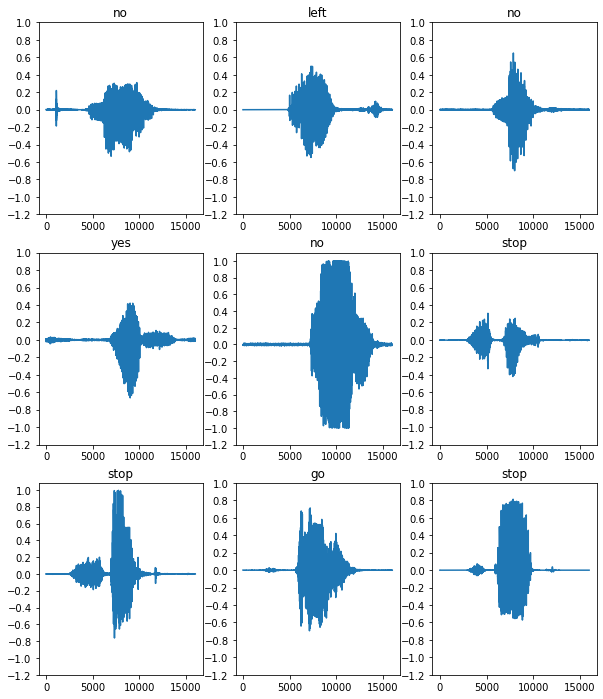

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


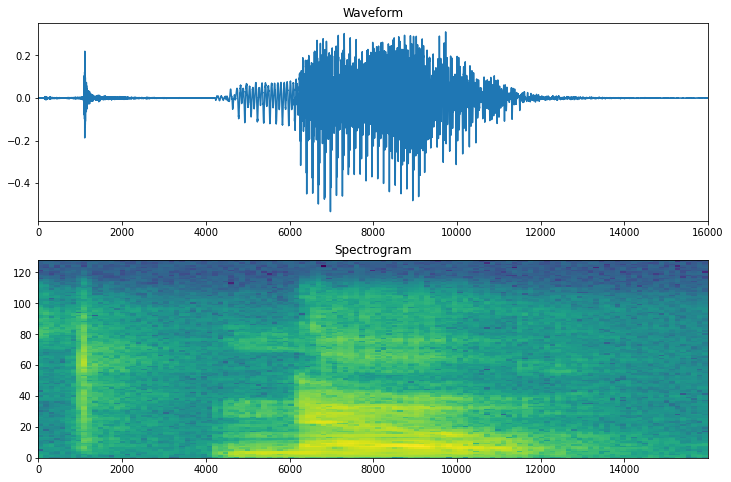

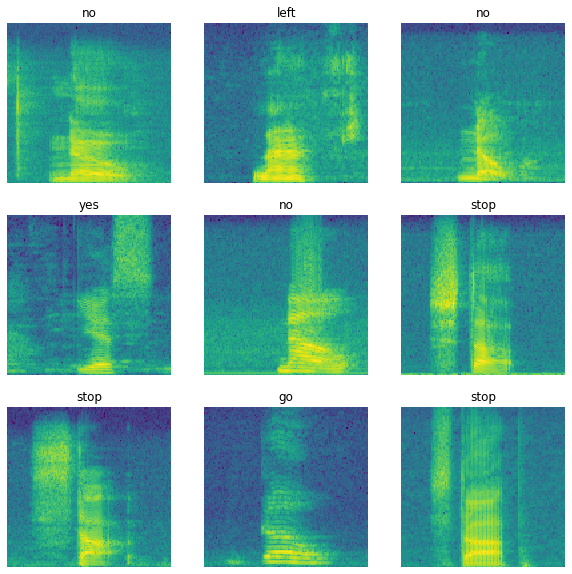

label
Tensor("strided_slice:0", shape=(), dtype=string)
waveform
Tensor("Squeeze:0", shape=(None,), dtype=float32)
label
Tensor("strided_slice:0", shape=(), dtype=string)
waveform
Tensor("Squeeze:0", shape=(None,), dtype=float32)


In [ ]:
import os
import pathlib
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D,MaxPooling2D,Flatten,LSTM,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.utils.np_utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
 
import librosa as lr
 
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
 
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)
 
 
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])
 
 
 
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 1000]
test_files = filenames[-600:]
 
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))
 
 
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)
 
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
 
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 
 
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  print("label")
  print(label)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  print("waveform")
  print(waveform)
  return waveform, label
 
 
 
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
 
 
 
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)
 
plt.show()
 
 
 
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
 
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)
 
  return spectrogram
 
 
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)
 
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))
 
 
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
 
 
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()
 
 
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id
 
 
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
 
 
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()
 
 
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds
 
 
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
 
 
 
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
 
 
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D,MaxPooling2D,Flatten,LSTM,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.utils.np_utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint

import librosa as lr

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (124, 129, 1)


In [ ]:
from keras.optimizers import Adam
from keras_radam import RAdam
from tensorflow.keras.layers import LeakyReLU

In [ ]:
#CNN of 10 layers
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation=hp.Choice('conv_1_activation', values = ['relu','elu']),
        input_shape=(124,129,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation=hp.Choice('conv_2_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation=hp.Choice('conv_3_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        activation=hp.Choice('conv_4_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_5_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_5_kernel', values = [3,5]),
        activation=hp.Choice('conv_5_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_6_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_6_kernel', values = [3,5]),
        activation=hp.Choice('conv_6_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_7_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_7_kernel', values = [3,5]),
        activation=hp.Choice('conv_7_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_8_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_8_kernel', values = [3,5]),
        activation=hp.Choice('conv_8_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_9_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_9_kernel', values = [3,5]),
        activation=hp.Choice('conv_9_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_10_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_10_kernel', values = [3,5]),
        activation=hp.Choice('conv_10_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('dense_1_activation', values = ['relu','elu'])
        
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('dense_2_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Dense(8, activation='softmax')
  ])
  
  model.compile(optimizer=RAdam(learning_rate=hp.Choice('learning_rate', values=[1e-2,1e-3])),
              loss=hp.Choice('loss_function',values=['sparse_categorical_crossentropy','hinge']),
              metrics=['accuracy'])
  
  return model

In [ ]:
import keras_tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [ ]:
tuner_search=RandomSearch(build_model,
                          objective=keras_tuner.Objective("loss",direction="min"),
                          max_trials=10,directory='output',project_name="mini_speech_commands2")

In [ ]:
tuner_search.search(train_ds,validation_data=val_ds,epochs=3)

In [ ]:
tuner_search.search_space_summary()

In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
print(tuner_search.get_best_hyperparameters(1)[0].values)

{'conv_1_filter': 64, 'conv_1_kernel': 3, 'conv_1_activation': 'elu', 'conv_2_filter': 96, 'conv_2_kernel': 5, 'conv_2_activation': 'relu', 'conv_3_filter': 112, 'conv_3_kernel': 5, 'conv_3_activation': 'relu', 'conv_4_filter': 80, 'conv_4_kernel': 3, 'conv_4_activation': 'relu', 'conv_5_filter': 128, 'conv_5_kernel': 5, 'conv_5_activation': 'relu', 'conv_6_filter': 48, 'conv_6_kernel': 3, 'conv_6_activation': 'relu', 'conv_7_filter': 48, 'conv_7_kernel': 5, 'conv_7_activation': 'relu', 'conv_8_filter': 96, 'conv_8_kernel': 3, 'conv_8_activation': 'relu', 'conv_9_filter': 80, 'conv_9_kernel': 3, 'conv_9_activation': 'relu', 'conv_10_filter': 80, 'conv_10_kernel': 5, 'conv_10_activation': 'elu', 'dense_1_units': 32, 'dense_1_activation': 'elu', 'dense_2_units': 48, 'dense_2_activation': 'elu', 'learning_rate': 0.01, 'loss_function': 'hinge'}


In [ ]:
print(tuner_search.get_best_models(num_models=1)[0].summary)

In [ ]:
model.summary()

In [ ]:
history=model.fit(train_ds,validation_data=val_ds, epochs=10)

Epoch 1/10
100/100 [==============================] - 84s 838ms/step - loss: 0.5602 - accuracy: 0.1198 - val_loss: 0.5676 - val_accuracy: 0.1300
Epoch 2/10
100/100 [==============================] - 85s 854ms/step - loss: 0.5601 - accuracy: 0.1194 - val_loss: 0.5624 - val_accuracy: 0.1220
Epoch 3/10
100/100 [==============================] - 86s 862ms/step - loss: 0.5601 - accuracy: 0.1256 - val_loss: 0.5729 - val_accuracy: 0.1210
Epoch 4/10
100/100 [==============================] - 88s 881ms/step - loss: 0.5601 - accuracy: 0.1216 - val_loss: 0.5746 - val_accuracy: 0.1290
Epoch 5/10
100/100 [==============================] - 89s 887ms/step - loss: 0.5600 - accuracy: 0.1275 - val_loss: 0.5657 - val_accuracy: 0.1270
Epoch 6/10
100/100 [==============================] - 89s 889ms/step - loss: 0.5600 - accuracy: 0.1286 - val_loss: 0.5668 - val_accuracy: 0.1220
Epoch 7/10
100/100 [==============================] - 88s 876ms/step - loss: 0.5600 - accuracy: 0.1266 - val_loss: 0.5668 - val_ac

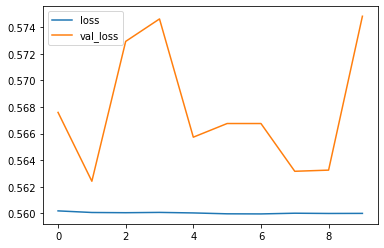

In [ ]:
#Accuracy for 10 layer CNN model
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

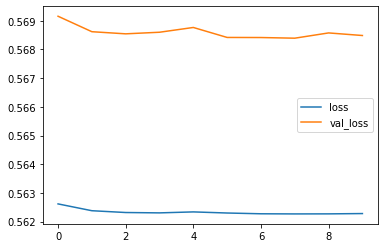

In [ ]:
#Accuracy for very simple model
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
#CNN of 11 layers
def build_model1(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation=hp.Choice('conv_1_activation', values = ['relu','elu']),
        input_shape=(124,129,1)
    ),      
     keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),                  
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation=hp.Choice('conv_2_activation', values = ['relu','elu']),
        input_shape=(124,129,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation=hp.Choice('conv_3_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        activation=hp.Choice('conv_4_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_5_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_5_kernel', values = [3,5]),
        activation=hp.Choice('conv_5_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_6_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_6_kernel', values = [3,5]),
        activation=hp.Choice('conv_6_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_7_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_7_kernel', values = [3,5]),
        activation=hp.Choice('conv_7_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_8_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_8_kernel', values = [3,5]),
        activation=hp.Choice('conv_8_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_9_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_9_kernel', values = [3,5]),
        activation=hp.Choice('conv_9_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_10_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_10_kernel', values = [3,5]),
        activation=hp.Choice('conv_10_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_11_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_11_kernel', values = [3,5]),
        activation=hp.Choice('conv_11_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('dense_1_activation', values = ['relu','elu'])
        
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('dense_2_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Dense(8, activation='softmax')
  ])
  
  model.compile(optimizer=RAdam(learning_rate=hp.Choice('learning_rate', values=[1e-2,1e-3])),
              loss=hp.Choice('loss_function',values=['sparse_categorical_crossentropy','hinge']),
              metrics=['accuracy'])
  
  return model

In [ ]:
tuner_search=RandomSearch(build_model1,
                          objective=keras_tuner.Objective("loss",direction="min"),
                          max_trials=10,directory='output',project_name="mini_speech_commands3")

In [ ]:
tuner_search.search(train_ds,validation_data=val_ds,epochs=3)

Trial 10 Complete [00h 04m 17s]
loss: 0.8487924337387085

Best loss So Far: 0.5622193813323975
Total elapsed time: 00h 55m 56s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_search.search_space_summary()

Search space summary
Default search space size: 39
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], '

In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
print(tuner_search.get_best_hyperparameters(1)[0].values)

{'conv_1_filter': 112, 'conv_1_kernel': 3, 'conv_1_activation': 'relu', 'conv_2_filter': 80, 'conv_2_kernel': 3, 'conv_2_activation': 'elu', 'conv_3_filter': 112, 'conv_3_kernel': 3, 'conv_3_activation': 'relu', 'conv_4_filter': 96, 'conv_4_kernel': 3, 'conv_4_activation': 'relu', 'conv_5_filter': 96, 'conv_5_kernel': 5, 'conv_5_activation': 'relu', 'conv_6_filter': 48, 'conv_6_kernel': 3, 'conv_6_activation': 'relu', 'conv_7_filter': 32, 'conv_7_kernel': 5, 'conv_7_activation': 'elu', 'conv_8_filter': 80, 'conv_8_kernel': 3, 'conv_8_activation': 'relu', 'conv_9_filter': 48, 'conv_9_kernel': 3, 'conv_9_activation': 'relu', 'conv_10_filter': 48, 'conv_10_kernel': 5, 'conv_10_activation': 'elu', 'conv_11_filter': 48, 'conv_11_kernel': 5, 'conv_11_activation': 'elu', 'dense_1_units': 96, 'dense_1_activation': 'relu', 'dense_2_units': 128, 'dense_2_activation': 'relu', 'learning_rate': 0.001, 'loss_function': 'hinge'}


In [ ]:
print(tuner_search.get_best_models(num_models=1)[0].summary)

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f19c86aa910>>


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 122, 127, 112)     1120      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 126, 112)     0         
_________________________________________________________________
dropout (Dropout)            (None, 121, 126, 112)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 124, 80)      80720     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 122, 112)     80752     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 116, 121, 112)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 116, 121, 112)     0

In [ ]:
history=model.fit(train_ds,validation_data=val_ds, epochs=10)

Epoch 1/10
100/100 [==============================] - 94s 893ms/step - loss: 0.5616 - accuracy: 0.1309 - val_loss: 0.5623 - val_accuracy: 0.1070
Epoch 2/10
100/100 [==============================] - 92s 924ms/step - loss: 0.5615 - accuracy: 0.1192 - val_loss: 0.5623 - val_accuracy: 0.1250
Epoch 3/10
100/100 [==============================] - 92s 915ms/step - loss: 0.5613 - accuracy: 0.1298 - val_loss: 0.5623 - val_accuracy: 0.1510
Epoch 4/10
100/100 [==============================] - 91s 911ms/step - loss: 0.5608 - accuracy: 0.1302 - val_loss: 0.5624 - val_accuracy: 0.1490
Epoch 5/10
100/100 [==============================] - 93s 928ms/step - loss: 0.5608 - accuracy: 0.1255 - val_loss: 0.5629 - val_accuracy: 0.1480
Epoch 6/10
100/100 [==============================] - 92s 917ms/step - loss: 0.5606 - accuracy: 0.1378 - val_loss: 0.5623 - val_accuracy: 0.1410
Epoch 7/10
100/100 [==============================] - 92s 921ms/step - loss: 0.5604 - accuracy: 0.1306 - val_loss: 0.5623 - val_ac

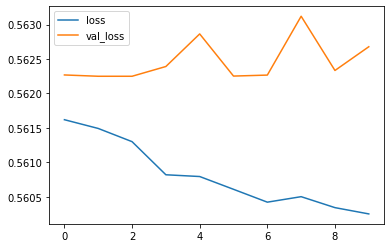

In [ ]:
#Accuracy for 11 layer CNN
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
#CNN of 9 layers
def build_model2(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation=hp.Choice('conv_1_activation', values = ['relu','elu']),
        input_shape=(124,129,1)
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation=hp.Choice('conv_2_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation=hp.Choice('conv_3_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        activation=hp.Choice('conv_4_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_5_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_5_kernel', values = [3,5]),
        activation=hp.Choice('conv_5_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_6_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_6_kernel', values = [3,5]),
        activation=hp.Choice('conv_6_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_7_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_7_kernel', values = [3,5]),
        activation=hp.Choice('conv_7_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_8_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_8_kernel', values = [3,5]),
        activation=hp.Choice('conv_8_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_9_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_9_kernel', values = [3,5]),
        activation=hp.Choice('conv_9_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('dense_1_activation', values = ['relu','elu'])
        
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('dense_2_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Dense(8, activation='softmax')
  ])
  
  model.compile(optimizer=RAdam(learning_rate=hp.Choice('learning_rate', values=[1e-2,1e-3])),
              loss=hp.Choice('loss_function',values=['sparse_categorical_crossentropy','hinge']),
              metrics=['accuracy'])
  
  return model

In [ ]:
tuner_search=RandomSearch(build_model2,
                          objective=keras_tuner.Objective("loss",direction="min"),
                          max_trials=10,directory='output',project_name="mini_speech_commands4")

In [ ]:
tuner_search.search(train_ds,validation_data=val_ds,epochs=3)

Trial 10 Complete [00h 04m 22s]
loss: 0.7040729522705078

Best loss So Far: 0.5609008073806763
Total elapsed time: 00h 50m 47s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_search.search_space_summary()

Search space summary
Default search space size: 33
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], '

In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
print(tuner_search.get_best_hyperparameters(1)[0].values)

{'conv_1_filter': 96, 'conv_1_kernel': 5, 'conv_1_activation': 'elu', 'conv_2_filter': 80, 'conv_2_kernel': 3, 'conv_2_activation': 'relu', 'conv_3_filter': 96, 'conv_3_kernel': 5, 'conv_3_activation': 'elu', 'conv_4_filter': 48, 'conv_4_kernel': 5, 'conv_4_activation': 'relu', 'conv_5_filter': 32, 'conv_5_kernel': 3, 'conv_5_activation': 'elu', 'conv_6_filter': 32, 'conv_6_kernel': 5, 'conv_6_activation': 'relu', 'conv_7_filter': 112, 'conv_7_kernel': 5, 'conv_7_activation': 'elu', 'conv_8_filter': 128, 'conv_8_kernel': 3, 'conv_8_activation': 'elu', 'conv_9_filter': 96, 'conv_9_kernel': 3, 'conv_9_activation': 'elu', 'dense_1_units': 48, 'dense_1_activation': 'elu', 'dense_2_units': 80, 'dense_2_activation': 'relu', 'learning_rate': 0.01, 'loss_function': 'hinge'}


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 125, 96)      2496      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 124, 96)      0         
_________________________________________________________________
dropout (Dropout)            (None, 119, 124, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 122, 80)      69200     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 118, 96)      192096    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 117, 96)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 117, 96)      0

In [ ]:
history=model.fit(train_ds,validation_data=val_ds, epochs=10)

Epoch 1/10
100/100 [==============================] - 81s 764ms/step - loss: 0.5606 - accuracy: 0.1187 - val_loss: 0.5627 - val_accuracy: 0.1570
Epoch 2/10
100/100 [==============================] - 80s 796ms/step - loss: 0.5602 - accuracy: 0.1283 - val_loss: 0.5634 - val_accuracy: 0.1270
Epoch 3/10
100/100 [==============================] - 81s 810ms/step - loss: 0.5600 - accuracy: 0.1184 - val_loss: 0.5624 - val_accuracy: 0.1390
Epoch 4/10
100/100 [==============================] - 81s 810ms/step - loss: 0.5599 - accuracy: 0.1356 - val_loss: 0.5623 - val_accuracy: 0.1280
Epoch 5/10
100/100 [==============================] - 81s 810ms/step - loss: 0.5599 - accuracy: 0.1277 - val_loss: 0.5623 - val_accuracy: 0.1220
Epoch 6/10
100/100 [==============================] - 81s 809ms/step - loss: 0.5599 - accuracy: 0.1380 - val_loss: 0.5627 - val_accuracy: 0.1200
Epoch 7/10
100/100 [==============================] - 81s 809ms/step - loss: 0.5599 - accuracy: 0.1366 - val_loss: 0.5624 - val_ac

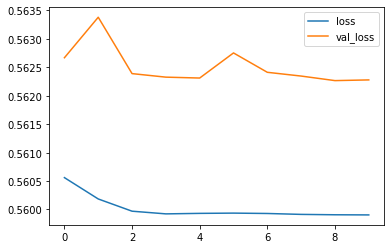

In [ ]:
#Accuracy for 9 layer CNN
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
#CNN of 8 layers
def build_model3(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation=hp.Choice('conv_1_activation', values = ['relu','elu']),
        input_shape=(124,129,1)
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation=hp.Choice('conv_2_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation=hp.Choice('conv_3_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        activation=hp.Choice('conv_4_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_5_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_5_kernel', values = [3,5]),
        activation=hp.Choice('conv_5_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Conv2D(
        filters=hp.Int('conv_6_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_6_kernel', values = [3,5]),
        activation=hp.Choice('conv_6_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_7_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_7_kernel', values = [3,5]),
        activation=hp.Choice('conv_7_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_8_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_8_kernel', values = [3,5]),
        activation=hp.Choice('conv_8_activation', values = ['relu','elu'])
        
    ),
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(1,1)
    ),
    keras.layers.Dropout(0.50),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('dense_1_activation', values = ['relu','elu'])
        
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('dense_2_activation', values = ['relu','elu'])
        
    ),
    keras.layers.Dense(8, activation='softmax')
  ])
  
  model.compile(optimizer=RAdam(learning_rate=hp.Choice('learning_rate', values=[1e-2,1e-3])),
              loss=hp.Choice('loss_function',values=['sparse_categorical_crossentropy','hinge']),
              metrics=['accuracy'])
  
  return model

In [ ]:
tuner_search=RandomSearch(build_model3,
                          objective=keras_tuner.Objective("loss",direction="min"),
                          max_trials=10,directory='output',project_name="mini_speech_commands2")

In [ ]:
tuner_search.search(train_ds,validation_data=val_ds,epochs=3)

NameError: ignored